# Load data

In [1]:
import re
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import (
    normalize_mid_points,
    read_data
)

In [2]:
keypoints = os.listdir('../data/keypoints')

# punch types: hook, jab, uper
keypoints_by_punch_types = [
    [i for i in keypoints if 'hook' in i],
    [i for i in keypoints if 'jab' in i],
    [i for i in keypoints if 'uper' in i]
]

In [3]:
keypoints_by_punch_types

[['id4_hook_1.npy',
  'id1_hook_2.npy',
  'id0_hook_2_reversed.npy',
  'id0_hook_2.npy',
  'id4_hook_2.npy',
  'id1_hook_2_reversed.npy',
  'id2_hook_2.npy',
  'id3_hook_1.npy',
  'id1_hook_1.npy',
  'id3_hook_2.npy',
  'id4_hook_2_reversed.npy',
  'id0_hook_1.npy',
  'id2_hook_1.npy',
  'id3_hook_2_reversed.npy',
  'id2_hook_2_reversed.npy'],
 ['id0_jab_2.npy',
  'id0_jab_1.npy',
  'id4_jab_2.npy',
  'id4_jab_2_reversed.npy',
  'id4_jab_1.npy',
  'id0_jab_2_reversed.npy',
  'id2_jab_2.npy',
  'id1_jab_2_reversed.npy',
  'id3_jab_1.npy',
  'id1_jab_1.npy',
  'id2_jab_2_reversed.npy',
  'id3_jab_2_reversed.npy',
  'id2_jab_1.npy',
  'id1_jab_2.npy',
  'id3_jab_2.npy'],
 ['id2_uper_1.npy',
  'id4_uper_2.npy',
  'id3_uper_2.npy',
  'id4_uper_1.npy',
  'id4_uper_2_reversed.npy',
  'id1_uper_2.npy',
  'id2_uper_2.npy',
  'id0_uper_2.npy',
  'id0_uper_2_reversed.npy',
  'id3_uper_2_reversed.npy',
  'id0_uper_1.npy',
  'id2_uper_2_reversed.npy',
  'id1_uper_2_reversed.npy',
  'id1_uper_1.npy'

In [96]:
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []

for keypoints in keypoints_by_punch_types:
    test_keypoints = random.choice(keypoints)

    for label in [i for i in keypoints if i != test_keypoints]:
        X, y = read_data(label, skip_midpoints=False)
        X_train_list.append(X)
        y_train_list.append(y)
    
    X, y = read_data(test_keypoints, skip_midpoints=False)
    X_val_list.append(X)
    y_val_list.append(y)


X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

id4_hook_1|reversed: False|data shape: (1054, 36)
--------------------
id1_hook_2|reversed: False|data shape: (792, 36)
--------------------
id0_hook_2|reversed: True|data shape: (1051, 36)
--------------------
id0_hook_2|reversed: False|data shape: (1051, 36)
--------------------
id4_hook_2|reversed: False|data shape: (1059, 36)
--------------------
id1_hook_2|reversed: True|data shape: (792, 36)
--------------------
id2_hook_2|reversed: False|data shape: (1041, 36)
--------------------
id3_hook_1|reversed: False|data shape: (1461, 36)
--------------------
id1_hook_1|reversed: False|data shape: (858, 36)
--------------------
id3_hook_2|reversed: False|data shape: (1297, 36)
--------------------
id4_hook_2|reversed: True|data shape: (1059, 36)
--------------------
id0_hook_1|reversed: False|data shape: (1100, 36)
--------------------
id2_hook_1|reversed: False|data shape: (1013, 36)
--------------------
id3_hook_2|reversed: True|data shape: (1297, 36)
--------------------
id2_hook_2|re

In [47]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((43470, 36), (43470,), (2913, 36), (2913,))

In [6]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

def format_feature_names(names, skip_midpoints=False, ndims=3):
    feature_names = []
    for name in list(KEYPOINT_DICT.keys()):
        feature_names.append(name+'-x')
        feature_names.append(name+'-y')
        if ndims==3:
            feature_names.append(name+'-z')
    feature_names.append('mid_point-x')
    feature_names.append('mid_point-y')
    if ndims==3:
        feature_names.append('mid_point-z')
    return feature_names

feature_names = format_feature_names(list(KEYPOINT_DICT.keys()), ndims=2, skip_midpoints=False)

In [7]:
df = pd.DataFrame(data=X_train, columns=feature_names)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
nose-x,43182.0,-0.219692,0.028797,-0.464482,-0.235833,-0.217313,-0.201472,0.361919
nose-y,43182.0,-0.046039,0.145787,-0.668847,-0.164652,-0.104115,0.107102,0.475557
left_eye-x,43182.0,-0.231652,0.030210,-0.394743,-0.249112,-0.229336,-0.212929,0.359797
left_eye-y,43182.0,-0.046907,0.143117,-0.627711,-0.165310,-0.102643,0.100345,0.477576
right_eye-x,43182.0,-0.232455,0.030264,-0.407856,-0.249950,-0.229828,-0.213503,0.359336
right_eye-y,43182.0,-0.041068,0.141889,-0.669672,-0.153929,-0.093830,0.105780,0.475477
left_ear-x,43182.0,-0.234810,0.029755,-0.474184,-0.254430,-0.233534,-0.215132,0.366997
left_ear-y,43182.0,-0.036461,0.105252,-0.630786,-0.126115,-0.057032,0.050732,0.474723
right_ear-x,43182.0,-0.236904,0.030354,-0.469636,-0.255958,-0.235402,-0.216710,0.363357
right_ear-y,43182.0,-0.019957,0.102845,-0.600944,-0.093449,-0.043014,0.065543,0.473494


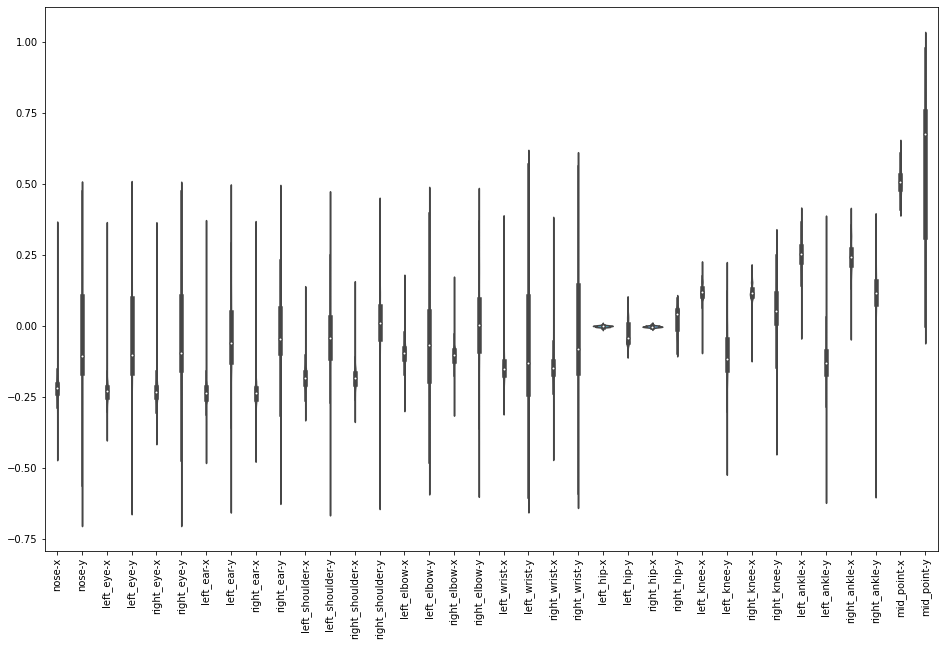

In [9]:
plt.figure(figsize=(16, 10))
ax = sns.violinplot(data=df)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [97]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second
# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_val.shape[0] // time_steps

X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 36)
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_val.shape

((1441, 30, 36), (105, 30, 36))

## CNN

In [98]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

In [99]:
X_dev = tf.expand_dims(X_train[:32], -1)
y_dev = y_train[:32]

X_dev.shape, y_dev.shape

(TensorShape([32, 30, 36, 1]), (32, 30, 7))

In [100]:
padd = tf.constant([[0,0], [2,2], [0,0], [0,0]])
x = tf.pad(X_dev, padd, 'CONSTANT')

x = K.layers.Conv2D(filters=7, kernel_size=(5, 36), activation='softmax')(x)
x

In [103]:
tf.squeeze(x, axis=-2)

<tf.Tensor: shape=(32, 30, 7), dtype=float32, numpy=
array([[[0.14603633, 0.15497646, 0.13758124, ..., 0.14189054,
         0.16722624, 0.11743198],
        [0.15074944, 0.164523  , 0.14295724, ..., 0.13901742,
         0.15653859, 0.10693169],
        [0.15296954, 0.15836497, 0.1405276 , ..., 0.14582999,
         0.15740848, 0.10791668],
        ...,
        [0.14623843, 0.16585447, 0.1372077 , ..., 0.13826351,
         0.16904697, 0.10818011],
        [0.14460866, 0.15384921, 0.13841535, ..., 0.14098145,
         0.1590879 , 0.11512377],
        [0.14786138, 0.16136016, 0.14095177, ..., 0.13616651,
         0.14792405, 0.11892313]],

       [[0.14541057, 0.15759899, 0.13582093, ..., 0.138641  ,
         0.17107205, 0.11547714],
        [0.14969711, 0.16652368, 0.14210318, ..., 0.1387428 ,
         0.15929931, 0.10542175],
        [0.15248767, 0.16065994, 0.13951924, ..., 0.14501101,
         0.1612028 , 0.10657557],
        ...,
        [0.14917475, 0.1634314 , 0.13703014, ..., 0.147

In [21]:
def model_builder(hp):
    # Hyperparams
    hp_ru = hp.Int('recurrent_units', min_value=16, max_value=128, step=8)
    hp_du1 = hp.Int('units1', min_value=16, max_value=128, step=8)
    hp_du2 = hp.Int('units2', min_value=16, max_value=128, step=8)
    hp_reg1 = hp.Float('dense1_reg', min_value=1e-4, max_value=1e-2)
    hp_reg2 = hp.Float('dense2_reg', min_value=1e-4, max_value=1e-2)
    
    hp_dp = hp.Float('dropout', min_value=0., max_value=0.4)
    hp_rec_dp = hp.Float('rec_dropout', min_value=0., max_value=0.4)
    hp_kernel_reg = hp.Float('kernel_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_recur_reg = hp.Float('recur_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    hp_act_reg = hp.Float('act_reg', min_value=1e-5, max_value=1e-3, sampling='log')
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    
    # Model
    norm = tf.keras.layers.LayerNormalization(axis=1)
    kernel_reg = K.regularizers.l2(hp_kernel_reg)
    recurrent_reg = K.regularizers.l2(hp_recur_reg)
    act_reg = K.regularizers.l2(hp_act_reg)
    padd = tf.constant([[0,0], [2,2], [0,0], [0,0]])
    x = tf.pad(x, padd, 'CONSTANT')
    x = K.layers.Conv2D(filters=7, kernel_size=(5, 36), activation='softmax')(x)
    out = tf.squeeze(x, axis=-2)

    model = K.Sequential([norm, lstm, dense1, dense2, out])
    model.compile(optimizer=K.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir2',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=1, validation_data=(X_val, y_val), 
             epochs=32, callbacks=[stop_early])

Trial 14 Complete [00h 00m 57s]
val_accuracy: 0.720370352268219

Best val_accuracy So Far: 0.7381481528282166
Total elapsed time: 00h 13m 08s

Search: Running Trial #15

Hyperparameter    |Value             |Best Value So Far 
recurrent_units   |128               |24                
units1            |128               |72                
units2            |80                |64                
dense1_reg        |0.0050079         |0.0046951         
dense2_reg        |0.0016573         |0.0012202         
dropout           |0.36845           |0.34404           
rec_dropout       |0.25512           |0.059489          
kernel_reg        |0.00022719        |8.5683e-05        
recur_reg         |1.087e-05         |9.0277e-05        
act_reg           |6.7795e-05        |0.0001386         
learning_rate     |0.0058216         |0.0064425         
tuner/epochs      |7                 |3                 
tuner/initial_e...|3                 |0                 
tuner/bracket     |2            

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_val, y_val), 
                    epochs=32,
                   callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Conclusion 

We need more data to avoid overfitting